# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

## Imports

In [1]:
import re
import time
import pickle
import logging

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
import spacy

In [2]:
SEED = 42
logging.basicConfig(level = logging.INFO, filename = "assignment.log",
                   format = '%(asctime)s  %(levelname)-10s %(message)s')

In [6]:
logging.info('First log message')

## Functions

In [7]:
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    doc = re.sub('\d', '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

In [8]:
def x_decomp(X,n_components=10):
    svd = TruncatedSVD(n_components=n_components,random_state=SEED)
    svd.fit(X)
    train_map = svd.components_.T
    
    return X@train_map

In [9]:
def score_logreg(X_train, X_test, y_train, y_test):
    LogReg = LogisticRegression(solver='lbfgs')
    parameters = {'C':[.5,1]}
    lr = GridSearchCV(LogReg, parameters, 
                      n_jobs=7, cv=5,
                      scoring='roc_auc',
                      refit=True)
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    #print('Logistic Regression Source Prediction')
    #print(roc_auc_score(y_test,y_pred))
    #print(accuracy_score(y_test,y_pred))
    
    return roc_auc_score(y_test,y_pred)

In [10]:
def embed_word2vec(doc,model):
    result = np.zeros(100)
    
    for wrd in doc:
        try:
            wrd_emb = model.wv[wrd]
        except KeyError:
            wrd_emb = np.zeros(100)
    
        result += wrd_emb
    
    norm = np.linalg.norm(result)
    if norm <= 0:
        norm = 1
        
    return result / norm

## Data

In [11]:
yelp = pd.read_csv('sentiment/yelps.csv')
yelp = yelp[yelp.positive.isin(['True','False'])]

yelp_y = (yelp['positive'].values == 'True')*1

In [12]:
# yelp_x = yelp['text']
with open("sentiment/yelp_pickle.txt", "rb") as fp:   # Unpickling
    yelp_x = pickle.load(fp)

In [13]:
test_size = .99
X_train, X_test, y_train, y_test = train_test_split(yelp_x, yelp_y, test_size=test_size, random_state=SEED)

## The loop

In [14]:
sizes = [.99, .95, .9, .8, .7, .6]
windows = [1,5,7] 
negatives = [0,5,7]
skip = [0,1]
results = []

In [15]:
print(time.ctime())
logging.info('Starting loop')
for test_size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(yelp_x, yelp_y, 
                                                        test_size=test_size, random_state=SEED)

    Vectorizer = TfidfVectorizer(min_df=5,
                                 max_df=.8,
                                 max_features=1000,
                                 #preprocessor=preprocess,
                                 #use_idf=False,
                                 stop_words='english')

    v_sparse = Vectorizer.fit_transform(X_train)
    
    #Embed onehots
    X_train_emb = np.asarray(v_sparse.todense())
    X_test_emb = Vectorizer.transform(X_test)

    #Score onehot
    score_1 = score_logreg(X_train_emb,X_test_emb,y_train,y_test)
    results.append([test_size,'onehot','a','b','c',score_1])
    del X_train_emb, X_test_emb
    
    #Re-format for word2vec
    W_train = np.array([x.split(' ') for x in X_train])
    W_test = np.array([x.split(' ') for x in X_test])
    del X_train, X_test
    
    logging.info('Finished onehot %s.' % test_size) 
    
    #Loop over attributes of word2vec
    for w in windows:
        for kneg in negatives:
            for sg in skip:
                #Build word2vec
                w2v = Word2Vec(W_train, size=100, min_count=2, workers=5, 
                               window=w, negative = kneg, sg = sg)

                #Embed word2vec
                W_train_emb = np.array([embed_word2vec(doc,w2v) for doc in W_train])
                W_test_emb = np.array([embed_word2vec(doc,w2v) for doc in W_test])
                del w2v

                score_2 = score_logreg(W_train_emb,W_test_emb,y_train,y_test)
                results.append([test_size,'word2vec',w,kneg,sg,score_2])
                del W_train_emb, W_test_emb
                
                logging.info('Finished w2v %s, %s, %s.' % (w, kneg, sg)) 

    print('Finished %s.' % test_size)
    print(time.ctime())

Tue May 12 14:55:01 2020


/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished 0.99.
Tue May 12 15:09:23 2020
Finished 0.95.
Tue May 12 15:23:43 2020
Finished 0.9.
Tue May 12 15:40:08 2020
Finished 0.8.
Tue May 12 15:55:22 2020


/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finished 0.7.
Tue May 12 16:10:00 2020


/home/bcohen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Finished 0.6.
Tue May 12 16:28:21 2020


## Analytics

For various training data sizes, I trained both a tfidf-vectorizer (that I call 'onehot') and word2vec, with a variety of parameter choices for word2vec.  Maximum vocabulary was always 1000 for the tfidf, and vector size 100 for the word2vec, but there were 18 different permutations of parameters for word2vec.  I trained the vectorizer on in-sample data only, trained a logistic regression (also in-sample only), and then tested on the remaining out of sample data.

Then I chose the best set of parameters from each run and the 12th best (representing a 'typical' or un-optimized run) and plotted their scores as a function of training data size.  There are other ways to do this but it seemed fine for what I'm after (in hindsight, I'd have chosen best and default parameters)

In [34]:
results_df = pd.DataFrame(results)
results_df.columns = ['test_size','algo','w','kneg','sg','score']

results_df['group_rk'] = results_df.groupby(['test_size','algo'])['score'].rank('first', ascending=False)

results_df = results_df[results_df['group_rk'].isin([1.,12.])]

results_df['training_size'] = 1 - results_df['test_size']
results_df['log_training'] = np.log(100000 * results_df['training_size'])

results_df['title'] = results_df['algo'] + '_' + np.where(results_df['group_rk']==1.,'best','typical')

results_df_g = results_df[['log_training','title','score']]

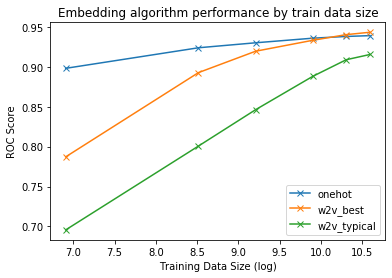

In [86]:
plt.plot(results_df_g[results_df_g.title=='onehot_best']['log_training'], 
         results_df_g[results_df_g.title=='onehot_best']['score'],label='onehot',marker='x')
plt.plot(results_df_g[results_df_g.title=='word2vec_best']['log_training'], 
         results_df_g[results_df_g.title=='word2vec_best']['score'],label='w2v_best',marker='x')
plt.plot(results_df_g[results_df_g.title=='word2vec_typical']['log_training'], 
         results_df_g[results_df_g.title=='word2vec_typical']['score'],label='w2v_typical',marker='x')
plt.legend(loc='lower right')
plt.title('Embedding algorithm performance by train data size')
plt.ylabel('ROC Score')
plt.xlabel('Training Data Size (log)')
plt.show()

The value of additional data seems higher in word2vec than for onehot encoding, which does pretty well on only a few reviews.

One reason it does so well is because I allowed a vocabuarly size of 1000 words, vs. only 100-dimensional vectors for word2vec.  With more challenging problems, this obviously won't scale, so it's good to see word2vec achieving the same level of performance on ~30k results. (The markers correspond to training data % on 100k observations of 1%, 5%, 10%, 20%, 30%, and 40%.

Now let's look at the average rank for each of the parameters

In [90]:
results_df = pd.DataFrame(results)
results_df.columns = ['test_size','algo','w','kneg','sg','score']

results_df['group_rk'] = results_df.groupby(['test_size','algo'])['score'].rank('first', ascending=False)

results_df = results_df[results_df.algo=='word2vec']

Window size:

In [96]:
results_df.groupby(['w'])['group_rk'].mean()

w
1    11.194444
5     8.916667
7     8.388889
Name: group_rk, dtype: float64

K-negative samples

In [98]:
results_df.groupby(['kneg'])['group_rk'].mean()

kneg
0    13.333333
5     8.027778
7     7.138889
Name: group_rk, dtype: float64

CBOW or Skip-Gram (CBOW=0, SG=1)

In [103]:
results_df.groupby(['sg'])['group_rk'].mean()

sg
0    10.648148
1     8.351852
Name: group_rk, dtype: float64

Top performers for larger data: large k-negative samples and larger windows do better, alongside general outperformance for skip-gram.

In [105]:
results_df[results_df.test_size==.6].sort_values('group_rk').head(10)

,test_size,algo,w,kneg,sg,score,group_rk
113,0.6,word2vec,7,7,1,0.943425,1.0
111,0.6,word2vec,7,5,1,0.943409,2.0
107,0.6,word2vec,5,7,1,0.941256,3.0
105,0.6,word2vec,5,5,1,0.941187,4.0
110,0.6,word2vec,7,5,0,0.937007,5.0
112,0.6,word2vec,7,7,0,0.936274,6.0
106,0.6,word2vec,5,7,0,0.934358,7.0
104,0.6,word2vec,5,5,0,0.933470,8.0
99,0.6,word2vec,1,5,1,0.924378,9.0
101,0.6,word2vec,1,7,1,0.923795,10.0


Top performers for smaller data: no k-negative samples dominates.  Once you introduce that, it still looks like skip gram outperforms.  Large window sizes still seem better.

In [108]:
results_df[results_df.test_size==.99].sort_values('group_rk').head(12)

,test_size,algo,w,kneg,sg,score,group_rk
1,0.99,word2vec,1,0,0,0.787175,1.0
2,0.99,word2vec,1,0,1,0.787175,2.0
7,0.99,word2vec,5,0,0,0.787175,3.0
8,0.99,word2vec,5,0,1,0.787175,4.0
13,0.99,word2vec,7,0,0,0.787175,5.0
14,0.99,word2vec,7,0,1,0.787175,6.0
18,0.99,word2vec,7,7,1,0.783188,7.0
16,0.99,word2vec,7,5,1,0.782733,8.0
12,0.99,word2vec,5,7,1,0.778490,9.0
10,0.99,word2vec,5,5,1,0.776207,10.0


## Old code

In [ ]:
Vectorizer = TfidfVectorizer(min_df=5,
                             max_df=.8,
                             max_features=1000,
                             #preprocessor=preprocess,
                             #use_idf=False,
                             stop_words='english')

v_sparse = Vectorizer.fit_transform(X_train)
v = np.asarray(v_sparse.todense())

# Get out the labels (keys of the vocabulary), sorted by index.
labels, _ = zip(*sorted(Vectorizer.vocabulary_.items(), key=lambda x: x[1]))

In [ ]:
#Embedding training data
start = time.time()
X_train_emb = v
print('%s seconds elapsed.' % str(round(time.time()-start,1)))

In [ ]:
start = time.time()
X_test_emb = Vectorizer.transform(X_test)
print('%s seconds elapsed.' % str(round(time.time()-start,1)))

### word2vec

In [ ]:
W_train = np.array([x.split(' ') for x in X_train])
W_test = np.array([x.split(' ') for x in X_test])

In [ ]:
w2v = Word2Vec(W_train, size=100, window=5, min_count=2)
#model.save("word2vec.model")

In [ ]:
W_train_emb = np.array([embed_word2vec(doc,w2v) for doc in W_train])
W_test_emb = np.array([embed_word2vec(doc,w2v) for doc in W_test])

### Logistic Regression

In [ ]:
def score_logreg(xtrain, xtest, y_train, y_test):
    LogReg = LogisticRegression(solver='lbfgs')
    parameters = {'C':[.5,1]}
    lr = GridSearchCV(LogReg, parameters, 
                      n_jobs=7, cv=5,
                      scoring='roc_auc',
                      refit=True)
    
    lr.fit(xtrain, y_train)
    y_pred = lr.predict(xtest)
    
    #print('Logistic Regression Source Prediction')
    #print(roc_auc_score(y_test,y_pred))
    #print(accuracy_score(y_test,y_pred))
    
    return roc_auc_score(y_test,y_pred)

In [ ]:
score_logreg(X_train_emb,X_test_emb,y_train,y_test)

In [ ]:
score_logreg(W_train_emb,W_test_emb,y_train,y_test)